# COVID-19 OLS Regression
This project looks at the use of:
1. OLS Regression to estimate the effect of the GoN COVID-19 POlicy changes and Vaccination on COVID-19 confirmed cases.

## Effect of Policy Meaures and Vaccination on Nigeria COVID-19 Confirmed Cases
Research Question: What is the impact of vaccination and government response policies on Nigeria COVID-19 confirmed cases.
Data Sources
1. NPHCDA: Daily vaccination call-in data
2. NCDC: daily COVID-19 cases, can be accessed at https://ncdc.gov.ng/diseases/sitreps/?cat=14&name=An%20update%20of%20COVID-19%20outbreak%20in%20Nigeria
3. The OxCGRT: provides a wide range of data on government responses to the COVID-19 pandemic, including measures related to school closures, mask mandates, and lockdown policies. This data can be used to help understand the impact of different policy measures on the spread of COVID-19 and can be used to control for confounding factors in your analysis. The data can be accessed at https://www.bsg.ox.ac.uk/research/covid-19-government-response-tracker

The data was merged into a CSV file which will be shared along this notebook

### Importing the libraries to be used

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
# import researchpy as re
from statsmodels.stats.outliers_influence import variance_inflation_factor

### EDA and data pre-processing
We created a new column:
1. Time after intervention: This variable captures the change in time with respect to the intervention (vaccination), which will be useful in understanding how the dependent variable changes before and after the intervention.
2. Vaccination Period: This variable will examine the impact of the vaccine rollout on the confirmed cases


In [2]:
# Load the data into a pandas DataFrame
df = pd.read_csv("time_series.csv")

# Convert the date column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')

# Create a 'Time' column that represents the time in days from the first date
df['Time'] = (df['Date'] - df['Date'].min()).dt.days

# Create a 'Vaccination_period' column that is 0 until March 14, 2021 and 1 afterwards
df['Vaccination_period'] = np.where(df['Date'] > '2021-03-14', 1, 0)

# Create a 'Time_after_intervention' column that represents the time in days after the intervention
df['Time_after_intervention'] = df['Time'] - df.loc[df['Vaccination_period'] == 1, 'Time'].min()

# set the index to the date column
df = df.set_index("Date")

In [3]:
df.index

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2022-10-28', '2022-10-29', '2022-10-30', '2022-10-31',
               '2022-11-01', '2022-11-02', '2022-11-03', '2022-11-04',
               '2022-11-05', '2022-11-06'],
              dtype='datetime64[ns]', name='Date', length=1041, freq=None)

In [5]:
df.columns

Index(['1st_dose', 'C1E_School closing', 'C2E_Workplace closing',
       'C3E_Cancel public events', 'C4E_Restrictions on gatherings',
       'C5E_Close public transport', 'C6E_Stay at home requirements',
       'C7E_Restrictions on internal movement',
       'C8EV_International travel controls',
       'H1E_Public information campaigns', 'H2E_Testing policy',
       'H3E_Contact tracing', 'H6E_Facial Coverings', 'H7E_Vaccination policy',
       'Confirmed_cases', 'Time', 'Vaccination_period',
       'Time_after_intervention'],
      dtype='object')

In [6]:
df.head()

,1st_dose,C1E_School closing,C2E_Workplace closing,C3E_Cancel public events,C4E_Restrictions on gatherings,C5E_Close public transport,C6E_Stay at home requirements,C7E_Restrictions on internal movement,C8EV_International travel controls,H1E_Public information campaigns,H2E_Testing policy,H3E_Contact tracing,H6E_Facial Coverings,H7E_Vaccination policy,Confirmed_cases,Time,Vaccination_period,Time_after_intervention
Date,,,,,,,,,,,,,,,,,,
2020-01-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-439
2020-01-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-438
2020-01-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,-437
2020-01-04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,-436
2020-01-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,-435


In [7]:
df.tail()

,1st_dose,C1E_School closing,C2E_Workplace closing,C3E_Cancel public events,C4E_Restrictions on gatherings,C5E_Close public transport,C6E_Stay at home requirements,C7E_Restrictions on internal movement,C8EV_International travel controls,H1E_Public information campaigns,H2E_Testing policy,H3E_Contact tracing,H6E_Facial Coverings,H7E_Vaccination policy,Confirmed_cases,Time,Vaccination_period,Time_after_intervention
Date,,,,,,,,,,,,,,,,,,
2022-11-02,295266,0,0,0,0,0,0,0,1,2,2,0,2,5,2,1036,1,597
2022-11-03,323580,0,0,0,0,0,0,0,1,2,2,0,2,5,13,1037,1,598
2022-11-04,307652,0,0,0,0,0,0,0,1,2,2,0,2,5,9,1038,1,599
2022-11-05,282945,0,0,0,0,0,0,0,1,2,2,0,2,5,11,1039,1,600
2022-11-06,167752,0,0,0,0,0,0,0,1,2,2,0,2,5,2,1040,1,601


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1041 entries, 2020-01-01 to 2022-11-06
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype
---  ------                                 --------------  -----
 0   1st_dose                               1041 non-null   int64
 1   C1E_School closing                     1041 non-null   int64
 2   C2E_Workplace closing                  1041 non-null   int64
 3   C3E_Cancel public events               1041 non-null   int64
 4   C4E_Restrictions on gatherings         1041 non-null   int64
 5   C5E_Close public transport             1041 non-null   int64
 6   C6E_Stay at home requirements          1041 non-null   int64
 7   C7E_Restrictions on internal movement  1041 non-null   int64
 8   C8EV_International travel controls     1041 non-null   int64
 9   H1E_Public information campaigns       1041 non-null   int64
 10  H2E_Testing policy                     1041 non-null   int64
 11  H3E_Contact 

###### Descriptive statistics for the numerical variables

In [8]:
re.summary_cont(df[['1st_dose', 'Confirmed_cases']])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,1st_dose,1041.0,62905.6052,93696.4861,2904.0089,57207.2207,68603.9897
1,Confirmed_cases,1041.0,255.4707,372.1529,11.5344,232.8373,278.1041


###### Descriptive statistics for ordinal variables
These variables are ordinal categorical variables and using them in an OLS regression we would assume that the differences between each order are equal and so they will be used as numerical variables in this regression. Additional information on this can be found at https://www.bsg.ox.ac.uk/research/covid-19-government-response-tracker

In [9]:
re.summary_cat(df[['C1E_School closing', 'C2E_Workplace closing',
       'C3E_Cancel public events', 'C4E_Restrictions on gatherings',
       'C5E_Close public transport', 'C6E_Stay at home requirements',
       'C7E_Restrictions on internal movement',
       'C8EV_International travel controls',
       'H1E_Public information campaigns', 'H2E_Testing policy',
       'H3E_Contact tracing', 'H6E_Facial Coverings', 'H7E_Vaccination policy']], ascending= False)

,Variable,Outcome,Count,Percent
0,C1E_School closing,0,604,58.02
1,,3,208,19.98
2,,1,133,12.78
3,,2,96,9.22
4,C2E_Workplace closing,0,419,40.25
5,,1,415,39.87
6,,2,171,16.43
7,,3,36,3.46
8,C3E_Cancel public events,1,577,55.43
9,,0,296,28.43


###### Checking for missing data

In [9]:
missing_values = df.isnull().sum().sort_values(ascending=False)
print(missing_values)

1st_dose                                 0
C1E_School closing                       0
Vaccination_period                       0
Time                                     0
Confirmed_cases                          0
H7E_Vaccination policy                   0
H6E_Facial Coverings                     0
H3E_Contact tracing                      0
H2E_Testing policy                       0
H1E_Public information campaigns         0
C8EV_International travel controls       0
C7E_Restrictions on internal movement    0
C6E_Stay at home requirements            0
C5E_Close public transport               0
C4E_Restrictions on gatherings           0
C3E_Cancel public events                 0
C2E_Workplace closing                    0
Time_after_intervention                  0
dtype: int64


<Axes: ylabel='Count'>

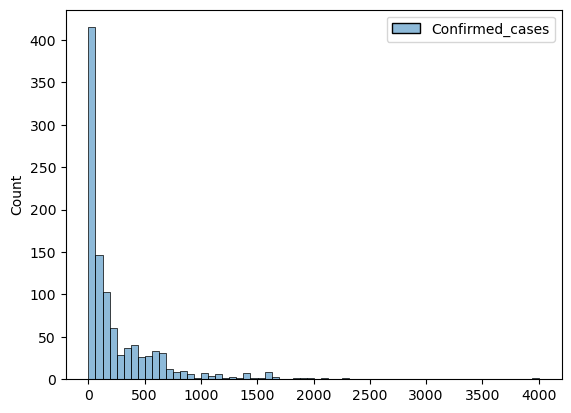

In [10]:
# Distribution of confirmed cases
sns.histplot(df[['Confirmed_cases']])

<Axes: ylabel='Count'>

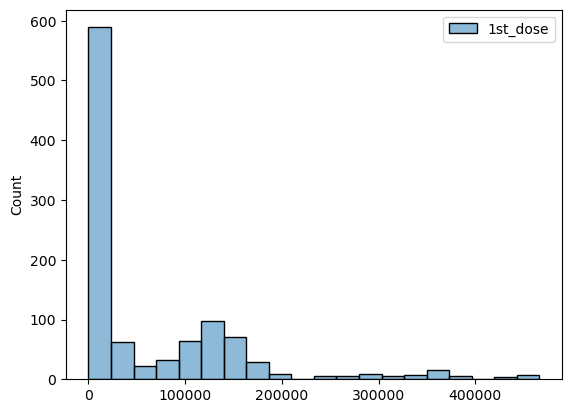

In [11]:
# Distribution of 1st Dose
sns.histplot(df[['1st_dose']])

<Axes: >

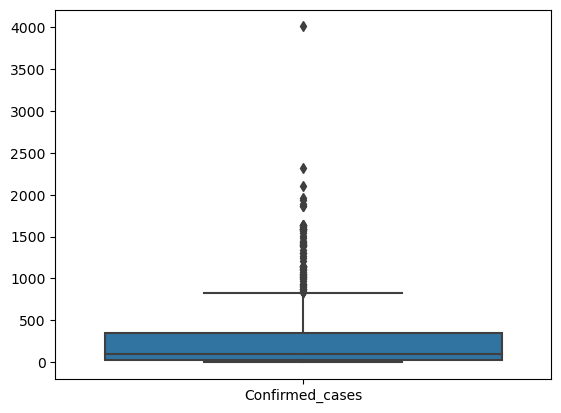

In [12]:
# Checking for outliers for confirmed cases
sns.boxplot(data=df[["Confirmed_cases"]])

<Axes: >

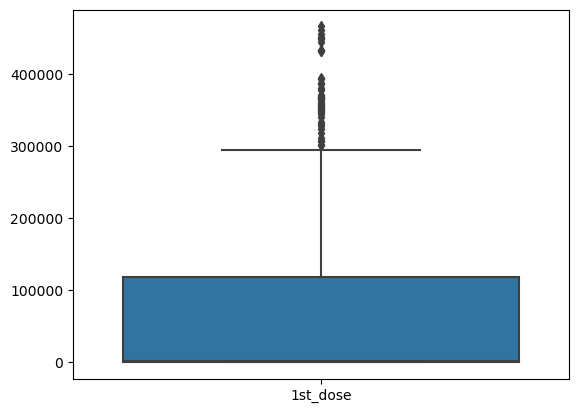

In [13]:
# Checking for outliers for Ist Dose
# vaccination began over 1 year into the COVID-19 pandemic, hence the high number of 0 vaccination
sns.boxplot(data=df[["1st_dose"]])

In [4]:
# Log transform the dependent and independent variables to address skewness
df['Confirmed_cases_log'] = np.log(df['Confirmed_cases'] + 1)
df['1st_dose_log'] = np.log(df['1st_dose'] + 1)

<Axes: ylabel='Count'>

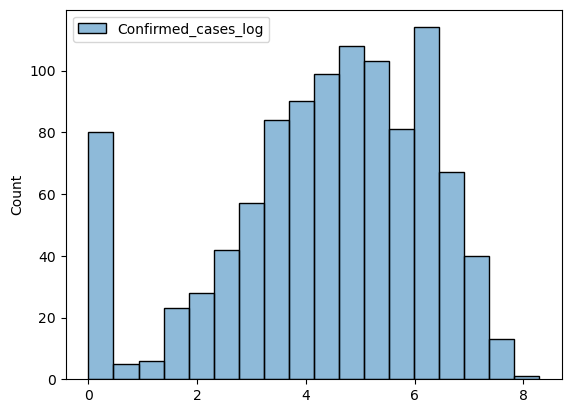

In [15]:
# Distribution of the log transformed dependent variable
sns.histplot(df[['Confirmed_cases_log']])

<Axes: ylabel='Count'>

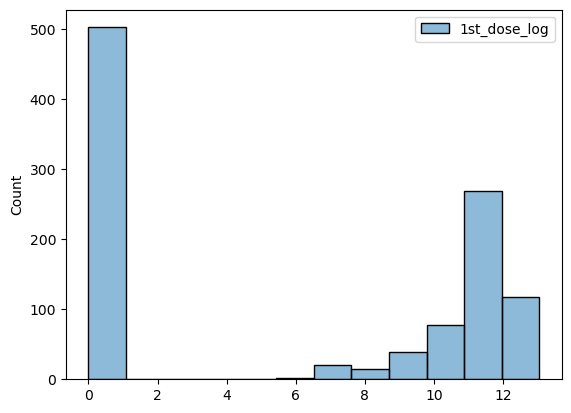

In [16]:
# Distribution of the log transformed vaccination for 1st dose
sns.histplot(df[['1st_dose_log']])

<Axes: >

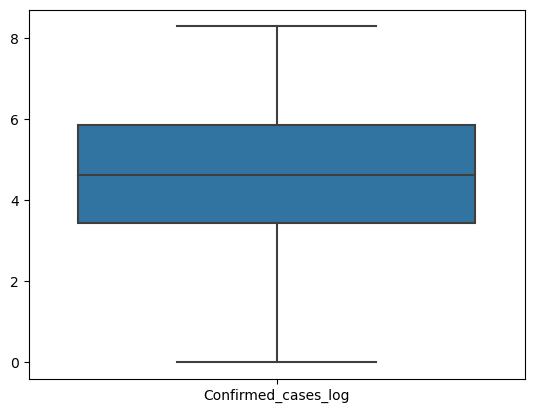

In [17]:
# Checking for outliers for log of confirmed cases
sns.boxplot(data=df[["Confirmed_cases_log"]])

<Axes: >

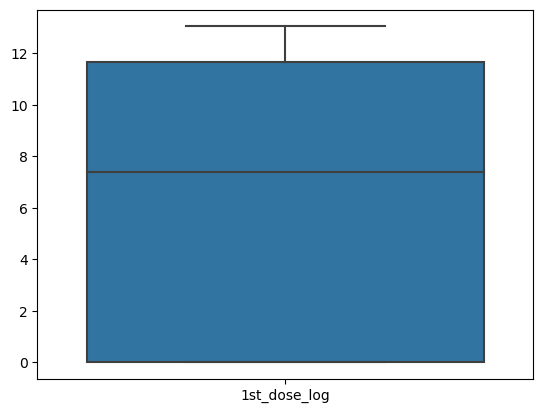

In [18]:
# Checking for outliers for the log of 1st dose
sns.boxplot(data=df[["1st_dose_log"]])

#### Correlation Analysis
To satisfy the assumption of multicollinearity in OLS regression we used 2 methods
1. Correlation plot
2. Variance Inflation Factor (VIF)

<Axes: >

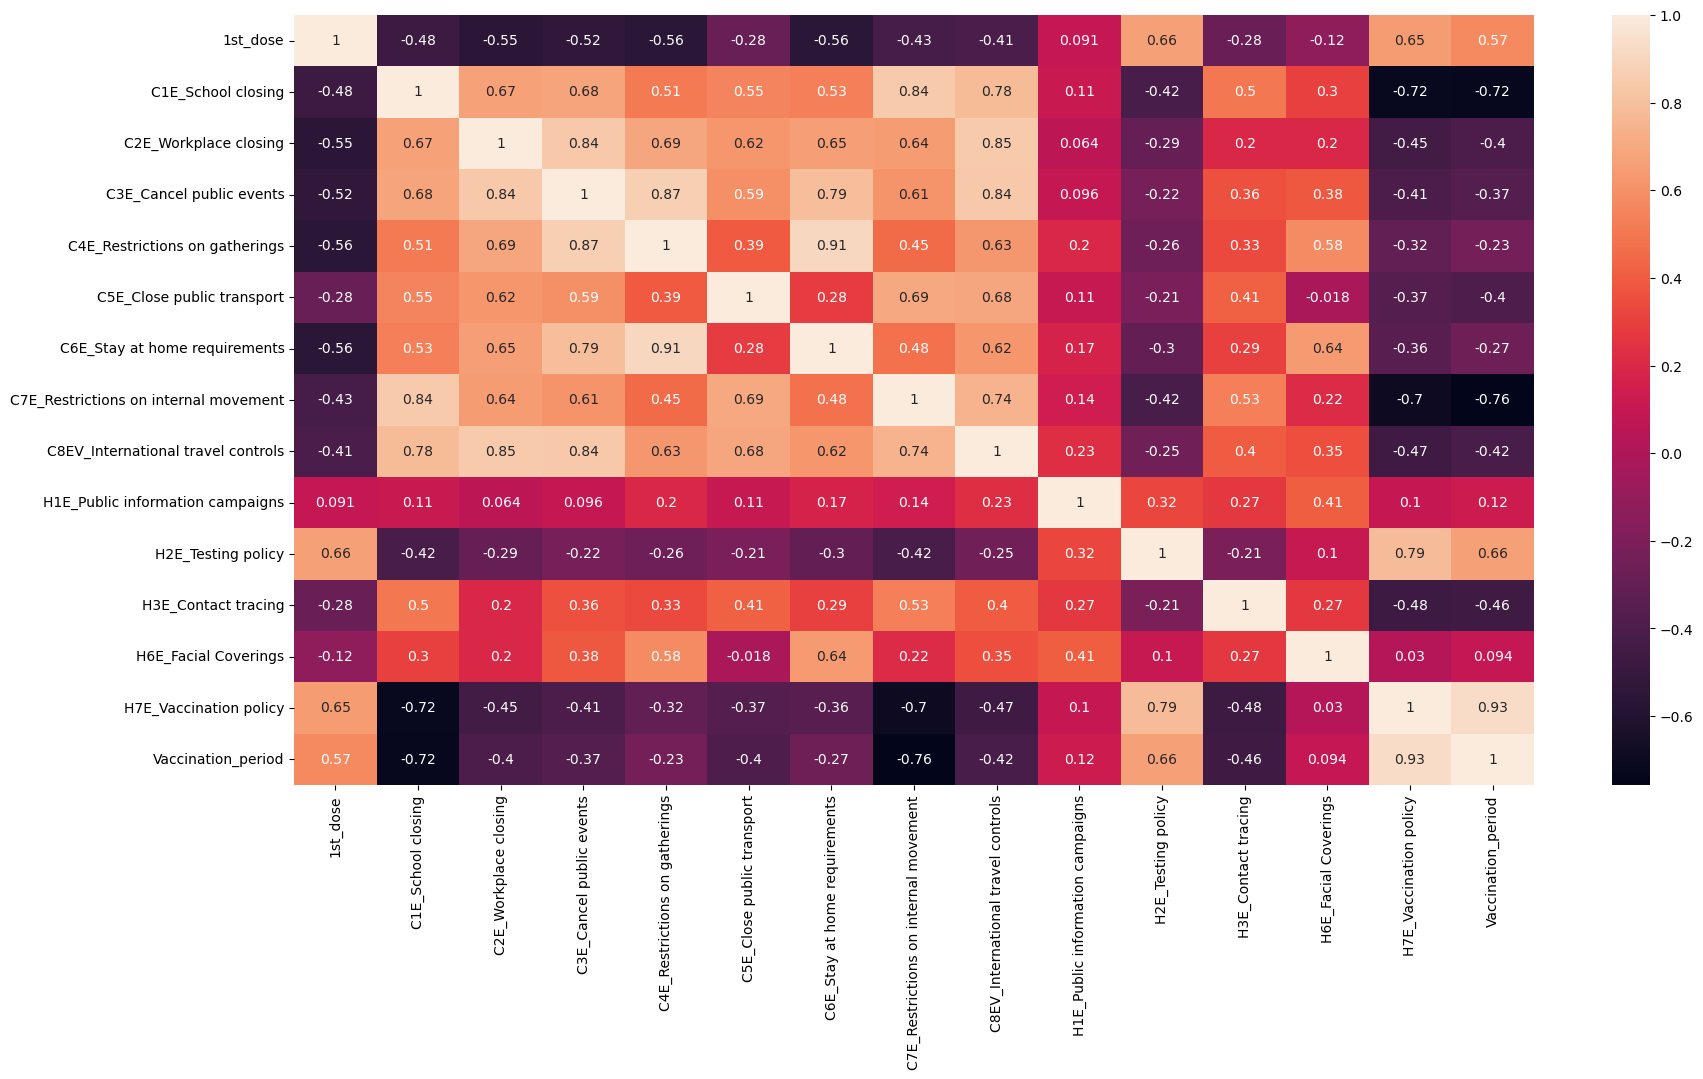

In [19]:
# Correlation Analysis
correlation = df[['1st_dose','C1E_School closing', 'C2E_Workplace closing',
       'C3E_Cancel public events', 'C4E_Restrictions on gatherings',
       'C5E_Close public transport', 'C6E_Stay at home requirements',
       'C7E_Restrictions on internal movement',
       'C8EV_International travel controls',
       'H1E_Public information campaigns', 'H2E_Testing policy',
       'H3E_Contact tracing', 'H6E_Facial Coverings', 'H7E_Vaccination policy', 'Vaccination_period']].corr()
plt.figure(figsize=(20,10)) 
sns.heatmap(correlation, annot=True)

In [5]:
# select the variables of interest
vars_ = ['1st_dose_log','C1E_School closing', 'C2E_Workplace closing',
       'C3E_Cancel public events', 'C4E_Restrictions on gatherings',
       'C5E_Close public transport', 'C6E_Stay at home requirements',
       'C7E_Restrictions on internal movement',
       'C8EV_International travel controls',
       'H1E_Public information campaigns', 'H2E_Testing policy',
       'H3E_Contact tracing', 'H6E_Facial Coverings', 'H7E_Vaccination policy', 'Time', 'Vaccination_period', 'Time_after_intervention']
X = df[vars_]

# calculate the VIF values for the variables
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# create a dataframe with the variables and their corresponding VIF values
vif_df = pd.DataFrame({'variable': X.columns, 'vif': vif})
print(vif_df)

                                 variable         vif
0                            1st_dose_log    9.327116
1                      C1E_School closing    7.426072
2                   C2E_Workplace closing    7.177051
3                C3E_Cancel public events   25.407569
4          C4E_Restrictions on gatherings   18.539701
5              C5E_Close public transport    4.230458
6           C6E_Stay at home requirements    9.622552
7   C7E_Restrictions on internal movement    9.376375
8      C8EV_International travel controls   14.523065
9        H1E_Public information campaigns    2.196599
10                     H2E_Testing policy    8.303514
11                    H3E_Contact tracing    2.131592
12                   H6E_Facial Coverings    4.655111
13                 H7E_Vaccination policy   17.552655
14                                   Time  154.687283
15                     Vaccination_period   20.481407
16                Time_after_intervention   20.682628


In [25]:
# select the variables of interest
vars_ = ['C3E_Cancel public events', 'C5E_Close public transport', 'C7E_Restrictions on internal movement',
                    'H1E_Public information campaigns', 'H7E_Vaccination policy',
                    'H2E_Testing policy', 'H3E_Contact tracing', 'H6E_Facial Coverings']
X = df[vars_]

# calculate the VIF values for the variables
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# create a dataframe with the variables and their corresponding VIF values
vif_df = pd.DataFrame({'variable': X.columns, 'vif': vif})
print(vif_df)

                                variable       vif
0               C3E_Cancel public events  2.386743
1             C5E_Close public transport  3.145733
2  C7E_Restrictions on internal movement  4.586032
3       H1E_Public information campaigns  1.524219
4                 H7E_Vaccination policy  6.413994
5                     H2E_Testing policy  3.543816
6                    H3E_Contact tracing  1.774915
7                   H6E_Facial Coverings  2.074387


###### Regression Analysis

In [44]:
# Scale the variables to have zero mean and unit variance
scaler = StandardScaler()
columns_to_scale = ['C3E_Cancel public events', 'C5E_Close public transport', 'C7E_Restrictions on internal movement',
                    'H1E_Public information campaigns', 'H7E_Vaccination policy',
                    'H2E_Testing policy', 'H3E_Contact tracing', 'H6E_Facial Coverings']

df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

def split_train_test(df, train_percentage=0.8):
    split_index = int(len(df) * train_percentage)
    df_train = df[:split_index].copy()  # Create a copy to avoid the SettingWithCopyWarning
    df_test = df[split_index:].copy()    # Create a copy to avoid the SettingWithCopyWarning
    return df_train, df_test

df1, df2 = split_train_test(df)

# Add an intercept column to the data
df1['Intercept'] = 1

# Fit an OLS model to the data
model = sm.OLS(df1['Confirmed_cases_log'], df1[['Intercept', 'C3E_Cancel public events',
                                                 'C5E_Close public transport', 'C7E_Restrictions on internal movement',
                                                 'H2E_Testing policy', 'H3E_Contact tracing',
                                                 'H6E_Facial Coverings', 'H7E_Vaccination policy']])
results = model.fit()

# Print the results
print(results.summary())

                             OLS Regression Results                            
Dep. Variable:     Confirmed_cases_log   R-squared:                       0.751
Model:                             OLS   Adj. R-squared:                  0.749
Method:                  Least Squares   F-statistic:                     354.7
Date:                 Wed, 20 Sep 2023   Prob (F-statistic):          1.18e-243
Time:                         21:20:44   Log-Likelihood:                -1169.9
No. Observations:                  832   AIC:                             2356.
Df Residuals:                      824   BIC:                             2394.
Df Model:                            7                                         
Covariance Type:             nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

## Interpretation of the OLS results

###### In interpreting the coeficients, we also have to keep in mind that the government policies were changed based on an increment in cases, so I would expect think that most of the coefficents will have a positive relationship with the dependent variable

Model Significance: The OLS regression model appears to be statistically significant as indicated by the F-statistic (F-statistic: 354.7, Prob (F-statistic): 1.18e-243). This suggests that the model, as a whole, is a good fit for the data, and at least one of the independent variables has a significant effect on the dependent variable.

R-squared and Adjusted R-squared: The R-squared value (0.751) suggests that approximately 75.1% of the variance in the dependent variable (Confirmed_cases_log) can be explained by the independent variables in the model. The adjusted R-squared value (0.749) indicates that the model fits the data well without overfitting.

C3E_Cancel public events (0.7969): For each unit increase in the "C3E_Cancel public events" variable (which represents the cancellation of public events), the estimated log-confirmed cases increase by approximately 0.7969. This coefficient is statistically significant, as its confidence interval (0.673 to 0.921) does not include zero.

C5E_Close public transport (-0.3629): For each unit increase in the "C5E_Close public transport" variable (which represents the closure of public transport), the estimated log-confirmed cases decrease by approximately 0.3629. This coefficient is statistically significant, as its confidence interval (-0.471 to -0.254) does not include zero.

C7E_Restrictions on internal movement (0.4592): For each unit increase in the "C7E_Restrictions on internal movement" variable (which represents restrictions on internal movement), the estimated log-confirmed cases increase by approximately 0.4592. This coefficient is statistically significant, as its confidence interval (0.321 to 0.597) does not include zero.

H2E_Testing policy (0.3915): For each unit increase in the "H2E_Testing policy" variable (which represents the testing policy), the estimated log-confirmed cases increase by approximately 0.3915. This coefficient is statistically significant, as its confidence interval (0.274 to 0.509) does not include zero.

H3E_Contact tracing (-0.3594): For each unit increase in the "H3E_Contact tracing" variable (which represents contact tracing), the estimated log-confirmed cases decrease by approximately 0.3594. This coefficient is statistically significant, as its confidence interval (-0.459 to -0.260) does not include zero.

H6E_Facial Coverings (1.1460): For each unit increase in the "H6E_Facial Coverings" variable (which represents the use of facial coverings), the estimated log-confirmed cases increase by approximately 1.1460. This coefficient is statistically significant, as its confidence interval (1.062 to 1.230) does not include zero.

H7E_Vaccination policy (-0.3118): For each unit increase in the "H7E_Vaccination policy" variable (which represents vaccination policy), the estimated log-confirmed cases decrease by approximately 0.3118. This coefficient is statistically significant, as its confidence interval (-0.472 to -0.152) does not include zero.

In the context of the confidence intervals, the coefficients represent estimated changes in the log-confirmed cases, and their significance suggests that these variables are associated with changes in the outcome variable. The confidence intervals provide a range of plausible values for the true population coefficients. Since none of the intervals include zero, it suggests that these variables have a statistically significant effect on log-confirmed cases.

Model Fit: The model appears to fit the data well with an Omnibus test, and the Jarque-Bera test indicates that the residuals are approximately normally distributed.

Durbin-Watson: The Durbin-Watson statistic (0.472) suggests that there may be autocorrelation present in the residuals. Further investigation into autocorrelation is recommended.

Prob(Omnibus) and Prob(JB): Both the Prob(Omnibus) and Prob(JB) values are very close to zero, indicating that the residuals are not normally distributed. This suggests that there may be some omitted variables or nonlinear relationships not captured by the model.

Cond. No.: The condition number (5.92) is relatively low, indicating that there is no strong multicollinearity among the independent variables.

Interpretation Note: It's important to note that while this model attempts to account for certain confounding variables, there are likely other confounding factors not included in the model (e.g., seasonality, testing rates, healthcare infrastructure) that could impact the results. Additionally, the coefficients represent associations, and causation cannot be inferred solely from this observational model.

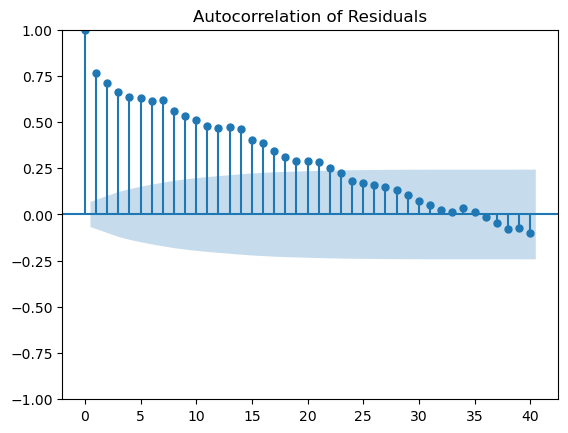

In [42]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Plot the autocorrelation of residuals
plot_acf(results.resid, lags=40, alpha=0.05)
plt.title('Autocorrelation of Residuals')
plt.show()

### Flaw of the OLS
Recall, the Durbin-Watson statistic (0.472) suggests that there may be autocorrelation present in the residuals. This can be confirmed from the ACF plot above where we see that there is significant autocorrelation at various lags.

###### Plotting the scatter plot of the residuals
The scatter plot shows the difference between the predicted values and the actual values, which are plotted against the predicted values. Ideally, if the model fits the data well, then the residuals should be randomly scattered around the zero line, and there should be no visible pattern or structure in the plot. On the other hand, if there is a visible pattern or structure in the plot, then it indicates that the model is not capturing some important features of the data, and the residuals may contain some systematic errors.

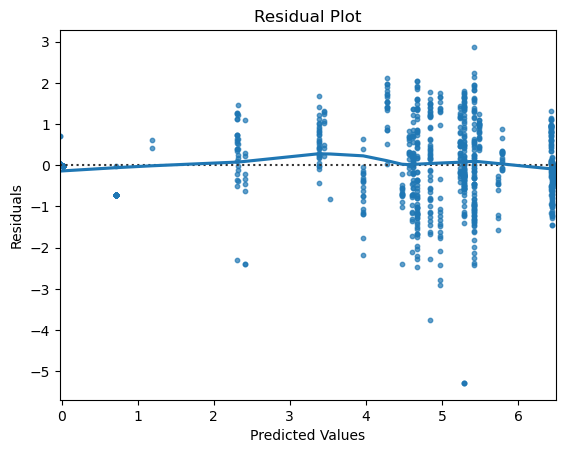

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate residuals
residuals = results.resid

# Create the residual plot
sns.residplot(x=results.fittedvalues, y=residuals, lowess=True, 
              scatter_kws={'s': 10, 'alpha': 0.7})
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


###### Distribution of the residuals
The histogram shows the distribution of the residuals, and ideally, it should be a bell-shaped curve centered around zero. If the histogram is skewed or has multiple peaks, then it suggests that the residuals are not normally distributed, which can indicate that the model is not appropriate for the data. In addition, if the histogram has a long tail on one side, then it indicates that the model is underfitting or overfitting the data, which can result in biased estimates and inaccurate predictions.

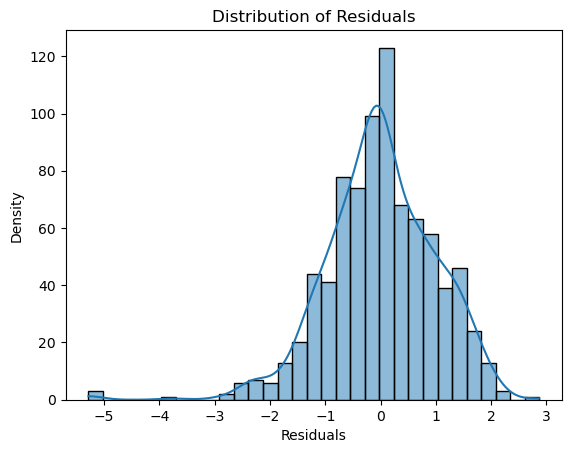

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a histogram of residuals using histplot
sns.histplot(residuals, kde=True)  # You can include kde=True to add a kernel density estimate
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Distribution of Residuals')
plt.show()
